<a href="https://colab.research.google.com/github/DinRazar/Unesco_parse/blob/main/Unesco_parser_xml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import xml.etree.ElementTree as ET
import json
import re

# Страны для фильтрации
target_countries = ['ru', 'by', 'ua', 'lt', 'lv', 'ee']

def parse_xml_to_geojson(xml_file_path, output_geojson_path):
    # Парсим XML
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Создаем структуру GeoJSON
    geojson = {
        "type": "FeatureCollection",
        "features": []
    }

    # Проходим по всем строкам
    for row in root.findall('row'):
        # Получаем страны объекта из iso_code
        iso_code_elem = row.find('iso_code')
        if iso_code_elem is None or iso_code_elem.text is None:
            continue

        iso_codes = iso_code_elem.text.split(',')

        # Проверяем, есть ли среди стран наши целевые
        if not any(country in iso_codes for country in target_countries):
            continue

        # Извлекаем информацию
        site_name = row.find('site').text if row.find('site') is not None else ""
        category = row.find('category').text if row.find('category') is not None else ""
        year = row.find('date_inscribed').text if row.find('date_inscribed') is not None else ""
        states = row.find('states').text if row.find('states') is not None else ""

        # Извлекаем геолокации
        geolocations = row.find('geolocations')
        if geolocations is None:
            continue

        # Для каждого POI создаем отдельную фичу
        for poi in geolocations.findall('poi'):
            iso2 = poi.find('iso2').text if poi.find('iso2') is not None else ""

            # Проверяем, что POI относится к целевой стране
            if iso2 not in target_countries:
                continue

            lat_elem = poi.find('latitude')
            lon_elem = poi.find('longitude')

            if lat_elem is None or lon_elem is None or lat_elem.text is None or lon_elem.text is None:
                continue

            try:
                lat = float(lat_elem.text)
                lon = float(lon_elem.text)
            except ValueError:
                continue

            # Создаем фичу
            feature = {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [lon, lat]
                },
                "properties": {
                    "site": site_name,
                    "category": category,
                    "year": year,
                    "country": iso2.upper(),
                    "states": states,
                    "iso_code": iso_codes,
                    "latitude": lat,
                    "longitude": lon
                }
            }

            geojson["features"].append(feature)

    # Сохраняем в файл
    with open(output_geojson_path, 'w', encoding='utf-8') as f:
        json.dump(geojson, f, ensure_ascii=False, indent=2)

    print(f"Найдено {len(geojson['features'])} объектов")
    print(f"Результат сохранен в: {output_geojson_path}")

    # Статистика по странам
    country_stats = {}
    for feature in geojson["features"]:
        country = feature["properties"]["country"]
        country_stats[country] = country_stats.get(country, 0) + 1

    print("\nСтатистика по странам:")
    for country, count in country_stats.items():
        print(f"  {country}: {count} объектов")

def create_simplified_dataset(xml_file_path, output_csv_path):
    """Создает упрощенный CSV датасет"""
    import csv

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['site', 'category', 'year', 'country', 'states', 'latitude', 'longitude']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()

        for row in root.findall('row'):
            iso_code_elem = row.find('iso_code')
            if iso_code_elem is None or iso_code_elem.text is None:
                continue

            iso_codes = iso_code_elem.text.split(',')

            if not any(country in iso_codes for country in target_countries):
                continue

            site_name = row.find('site').text if row.find('site') is not None else ""
            category = row.find('category').text if row.find('category') is not None else ""
            year = row.find('date_inscribed').text if row.find('date_inscribed') is not None else ""
            states = row.find('states').text if row.find('states') is not None else ""

            geolocations = row.find('geolocations')
            if geolocations is None:
                continue

            for poi in geolocations.findall('poi'):
                iso2 = poi.find('iso2').text if poi.find('iso2') is not None else ""

                if iso2 not in target_countries:
                    continue

                lat_elem = poi.find('latitude')
                lon_elem = poi.find('longitude')

                if lat_elem is None or lon_elem is None or lat_elem.text is None or lon_elem.text is None:
                    continue

                try:
                    lat = float(lat_elem.text)
                    lon = float(lon_elem.text)
                except ValueError:
                    continue

                writer.writerow({
                    'site': site_name,
                    'category': category,
                    'year': year,
                    'country': iso2.upper(),
                    'states': states,
                    'latitude': lat,
                    'longitude': lon
                })

    print(f"\nCSV датасет сохранен в: {output_csv_path}")

# Основная часть программы
if __name__ == "__main__":
    xml_file = "/content/xml.xml"  # Ваш XML файл
    geojson_output = "unesco_objects_baltics.geojson"
    csv_output = "unesco_objects_baltics.csv"

    # Создаем GeoJSON
    parse_xml_to_geojson(xml_file, geojson_output)

    # Создаем CSV для удобного анализа
    create_simplified_dataset(xml_file, csv_output)

    # Дополнительная информация
    print("\n" + "="*50)
    print("ДАННЫЕ ГОТОВЫ К ИСПОЛЬЗОВАНИЮ")
    print("="*50)
    print("\nФорматы данных:")
    print("1. GeoJSON - для визуализации на картах")
    print("2. CSV - для анализа в Excel/Pandas")
    print("\nПример использования GeoJSON в Python:")
    print("""
import geopandas as gpd
import matplotlib.pyplot as plt

# Загрузка данных
gdf = gpd.read_file('unesco_objects_baltics.geojson')

# Визуализация
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(column='country', legend=True, ax=ax, markersize=50)
plt.title('Объекты ЮНЕСКО в странах Балтии и соседних')
plt.show()
""")

Найдено 262 объектов
Результат сохранен в: unesco_objects_baltics.geojson

Статистика по странам:
  UA: 42 объектов
  BY: 8 объектов
  LT: 7 объектов
  LV: 4 объектов
  EE: 4 объектов
  RU: 197 объектов

CSV датасет сохранен в: unesco_objects_baltics.csv

ДАННЫЕ ГОТОВЫ К ИСПОЛЬЗОВАНИЮ

Форматы данных:
1. GeoJSON - для визуализации на картах
2. CSV - для анализа в Excel/Pandas

Пример использования GeoJSON в Python:

import geopandas as gpd
import matplotlib.pyplot as plt

# Загрузка данных
gdf = gpd.read_file('unesco_objects_baltics.geojson')

# Визуализация
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(column='country', legend=True, ax=ax, markersize=50)
plt.title('Объекты ЮНЕСКО в странах Балтии и соседних')
plt.show()



In [ ]:
!pip install folium geopandas pandas requests pillow -q

In [7]:
import folium
import geopandas as gpd
import pandas as pd
import json
import requests
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from folium import IFrame
import base64

# Загрузка GeoJSON данных
print("Загрузка данных...")
with open('unesco_objects_baltics.geojson', 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Преобразуем в GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Словарь для цвета стран
country_colors = {
    'RU': 'red',     # Россия
    'BY': 'green',   # Беларусь
    'UA': 'blue',    # Украина
    'LT': 'yellow',  # Литва
    'LV': 'orange',  # Латвия
    'EE': 'purple'   # Эстония
}

# Словарь для полных названий стран
country_names = {
    'RU': 'Россия',
    'BY': 'Беларусь',
    'UA': 'Украина',
    'LT': 'Литва',
    'LV': 'Латвия',
    'EE': 'Эстония'
}

# Скачиваем флаги стран
print("Загрузка флагов стран...")
flags = {}
flag_urls = {
    'RU': 'https://flagcdn.com/w40/ru.png',
    'BY': 'https://flagcdn.com/w40/by.png',
    'UA': 'https://flagcdn.com/w40/ua.png',
    'LT': 'https://flagcdn.com/w40/lt.png',
    'LV': 'https://flagcdn.com/w40/lv.png',
    'EE': 'https://flagcdn.com/w40/ee.png'
}

for country_code, url in flag_urls.items():
    try:
        response = requests.get(url)
        flags[country_code] = response.content
        print(f"  ✓ Флаг {country_names[country_code]} загружен")
    except Exception as e:
        print(f"  ✗ Ошибка загрузки флага {country_names[country_code]}: {e}")

# Упрощенная функция для создания круглого маркера с флагом
def create_flag_icon(country_code):
    if country_code in flags:
        try:
            # Создаем круглый флаг
            img = Image.open(BytesIO(flags[country_code]))

            # Создаем круглую маску
            mask = Image.new('L', img.size, 0)
            draw = ImageDraw.Draw(mask)
            draw.ellipse([(0, 0), img.size], fill=255)

            # Применяем маску
            img.putalpha(mask)

            # Сохраняем в буфер
            buffered = BytesIO()
            img.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            # Создаем HTML для иконки
            html = f'''
            <div style="
                border-radius: 50%;
                overflow: hidden;
                width: 40px;
                height: 40px;
                border: 2px solid white;
                box-shadow: 0 2px 4px rgba(0,0,0,0.3);
            ">
                <img src="data:image/png;base64,{img_str}"
                     style="width: 100%; height: 100%; object-fit: cover;">
            </div>
            '''
            return folium.DivIcon(html=html)
        except Exception as e:
            print(f"  Ошибка обработки флага {country_code}: {e}")
            # Используем цветной кружок как запасной вариант

    # Альтернатива: цветной кружок с буквой страны
    return folium.Icon(
        color=country_colors.get(country_code, 'gray'),
        icon='circle',
        icon_color='white',
        prefix='fa',
        html=f'<div style="font-size: 12px; font-weight: bold;">{country_code}</div>'
    )

# Функция для создания поп-апа с информацией
def create_popup_html(row):
    html = f"""
    <div style="min-width: 250px; font-family: Arial, sans-serif;">
        <h4 style="margin-top: 0; color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px;">
            {row['site']}
        </h4>
        <p><strong>📍 Страна:</strong> <span style="color: {country_colors.get(row['country'], '#000')};
                        font-weight: bold;">{country_names.get(row['country'], row['country'])}</span></p>
        <p><strong>📋 Категория:</strong> {row['category']}</p>
        <p><strong>📅 Год внесения:</strong> <span style="background-color: #f0f0f0; padding: 2px 6px;
                        border-radius: 3px;">{row['year']}</span></p>
        <p><strong>🌍 Страны-участники:</strong> <br>{row['states']}</p>
        <p><strong>🗺️ Координаты:</strong><br>
           <span style="font-family: monospace;">Широта: {row['latitude']:.4f}<br>Долгота: {row['longitude']:.4f}</span></p>
    </div>
    """
    return html

# Создаем базовую карту (центрируем на регионе)
print("\nСоздание карты...")
center_lat = gdf['latitude'].mean()
center_lon = gdf['longitude'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=4,
    tiles='CartoDB positron',
    control_scale=True
)

# Добавляем слой кластеризации
from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Добавляем маркеры на карту
print("Добавление маркеров на карту...")
for idx, row in gdf.iterrows():
    icon = create_flag_icon(row['country'])
    popup = folium.Popup(create_popup_html(row), max_width=300)

    # Создаем маркер
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup,
        icon=icon,
        tooltip=f"📍 {row['site']} ({country_names.get(row['country'], row['country'])})"
    ).add_to(marker_cluster)

# Создаем FeatureGroup для каждой страны
for country_code in country_colors.keys():
    country_data = gdf[gdf['country'] == country_code]
    if len(country_data) > 0:
        fg = folium.FeatureGroup(
            name=f"🇷🇺 {country_names[country_code]} ({len(country_data)})",
            overlay=True
        )

        # Добавляем маркеры в FeatureGroup
        for idx, row in country_data.iterrows():
            icon = folium.Icon(
                color=country_colors.get(country_code, 'gray'),
                icon='circle',
                icon_color='white',
                prefix='fa'
            )

            popup = folium.Popup(create_popup_html(row), max_width=300)

            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=popup,
                icon=icon
            ).add_to(fg)

        fg.add_to(m)

# Добавляем контроль слоев
folium.LayerControl().add_to(m)

# Добавляем красивую легенду
legend_html = '''
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 220px;
    height: auto;
    background-color: white;
    border: 2px solid #3498db;
    border-radius: 8px;
    z-index: 9999;
    font-family: Arial, sans-serif;
    font-size: 14px;
    padding: 15px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.15);
">
    <h4 style="
        margin-top: 0;
        margin-bottom: 15px;
        color: #2c3e50;
        border-bottom: 1px solid #eee;
        padding-bottom: 8px;
    ">
        🗺️ Объекты ЮНЕСКО
    </h4>
'''

for code, name in country_names.items():
    color = country_colors[code]
    count = len(gdf[gdf['country'] == code])

    # Для стран с флагами показываем флаг, для остальных - цветной кружок
    if code in flags:
        try:
            img = Image.open(BytesIO(flags[code])).resize((20, 20))
            buffered = BytesIO()
            img.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            legend_html += f'''
            <div style="display: flex; align-items: center; margin: 8px 0;">
                <img src="data:image/png;base64,{img_str}"
                     style="width: 20px; height: 20px; border-radius: 50%; border: 1px solid #ccc; margin-right: 10px;">
                <span>{name}: <strong>{count}</strong></span>
            </div>
            '''
        except:
            # Если не удалось обработать флаг, используем цветной кружок
            legend_html += f'''
            <div style="display: flex; align-items: center; margin: 8px 0;">
                <div style="background-color: {color}; width: 20px; height: 20px;
                            border-radius: 50%; margin-right: 10px; border: 1px solid #ccc;"></div>
                <span>{name}: <strong>{count}</strong></span>
            </div>
            '''
    else:
        legend_html += f'''
        <div style="display: flex; align-items: center; margin: 8px 0;">
            <div style="background-color: {color}; width: 20px; height: 20px;
                        border-radius: 50%; margin-right: 10px; border: 1px solid #ccc;"></div>
            <span>{name}: <strong>{count}</strong></span>
        </div>
        '''

legend_html += '''
    <hr style="margin: 15px 0; border: none; border-top: 1px solid #eee;">
    <div style="text-align: center; color: #7f8c8d; font-size: 12px;">
        Всего объектов: <strong>{}</strong>
    </div>
</div>
'''.format(len(gdf))

m.get_root().html.add_child(folium.Element(legend_html))

# Добавляем заголовок
title_html = '''
<div style="
    position: fixed;
    top: 10px;
    left: 50px;
    right: 50px;
    z-index: 1000;
    background-color: rgba(255, 255, 255, 0.95);
    padding: 12px 20px;
    border-radius: 8px;
    border: 2px solid #3498db;
    font-family: Arial, sans-serif;
    box-shadow: 0 4px 12px rgba(0,0,0,0.1);
">
    <h2 style="margin: 0; color: #2c3e50; font-size: 20px;">
        🏛️ Объекты Всемирного наследия ЮНЕСКО
    </h2>
    <p style="margin: 5px 0 0 0; color: #7f8c8d; font-size: 14px;">
        Восточная Европа и страны Балтии
    </p>
</div>
'''

m.get_root().html.add_child(folium.Element(title_html))

# # Добавляем кнопки управления
# controls_html = '''
# <div style="
#     position: fixed;
#     top: 100px;
#     right: 20px;
#     z-index: 1000;
#     background-color: white;
#     border-radius: 8px;
#     border: 1px solid #ddd;
#     padding: 10px;
#     box-shadow: 0 2px 6px rgba(0,0,0,0.1);
# ">
#     <div style="font-weight: bold; margin-bottom: 5px;">Быстрые действия:</div>
#     <button onclick="document.querySelector('.leaflet-control-layers').click()"
#             style="background: #3498db; color: white; border: none; padding: 5px 10px;
#                    border-radius: 4px; cursor: pointer; margin: 2px;">
#         Слои карты
#     </button>
#     <button onclick="window.open('unesco_map.html', '_blank')"
#             style="background: #27ae60; color: white; border: none; padding: 5px 10px;
#                    border-radius: 4px; cursor: pointer; margin: 2px;">
#         Сохранить карту
#     </button>
# </div>
# '''

# m.get_root().html.add_child(folium.Element(controls_html))

# # Показываем статистику
# print(f"\n📊 СТАТИСТИКА ОБЪЕКТОВ:")
# print("=" * 40)
# for code, name in country_names.items():
#     count = len(gdf[gdf['country'] == code])
#     print(f"  🇷🇺 {name}: {count} объектов")

# print(f"\nВсего объектов: {len(gdf)}")
# print(f"\n📈 Распределение по категориям:")
# for category in gdf['category'].unique():
#     count = len(gdf[gdf['category'] == category])
#     print(f"  {category}: {count} объектов")

# Отображаем карту
print("\n" + "=" * 60)
print("✅ Карта успешно создана! Отображаю...")
print("=" * 60 + "\n")
m

Загрузка данных...
Загрузка флагов стран...
  ✓ Флаг Россия загружен
  ✓ Флаг Беларусь загружен
  ✓ Флаг Украина загружен
  ✓ Флаг Литва загружен
  ✓ Флаг Латвия загружен
  ✓ Флаг Эстония загружен

Создание карты...
Добавление маркеров на карту...
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка обработки флага UA: cannot write mode PA as PNG
  Ошибка об

/tmp/ipython-input-905587877.py:101: UserWarning: color argument of Icon should be one of: {'darkblue', 'darkpurple', 'darkred', 'white', 'orange', 'lightgreen', 'lightblue', 'beige', 'black', 'purple', 'darkgreen', 'pink', 'gray', 'red', 'cadetblue', 'green', 'lightred', 'lightgray', 'blue'}.
  return folium.Icon(
/tmp/ipython-input-905587877.py:169: UserWarning: color argument of Icon should be one of: {'darkblue', 'darkpurple', 'darkred', 'white', 'orange', 'lightgreen', 'lightblue', 'beige', 'black', 'purple', 'darkgreen', 'pink', 'gray', 'red', 'cadetblue', 'green', 'lightred', 'lightgray', 'blue'}.
  icon = folium.Icon(


  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: cannot write mode PA as PNG
  Ошибка обработки флага RU: ca

4. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА НАБОРА ДАННЫХ

-- Программные средства обработки данных
Название программных средств обработки данных: Python 3.11
Используемые библиотеки: pandas, geopandas, shapely, matplotlib, seaborn, requests

-- Ознакомление с данными
Размер датасета: 262 строк, 7 столбцов

Первые 5 строк:
                                                                                site category  year country                                                                                                                                                                   states   latitude  longitude
0  Ancient and Primeval Beech Forests of the Carpathians and Other Regions of Europe  Natural  2007      UA  Albania,Austria,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Czechia,France,Germany,Italy,North Macedonia,Poland,Romania,Slovakia,Slovenia,Spain,Switzerland,Ukraine  47.940000  24.309000
1  Ancient and Primeval Beech Forests of the Carpathians and Other Regions of Europe  Natura

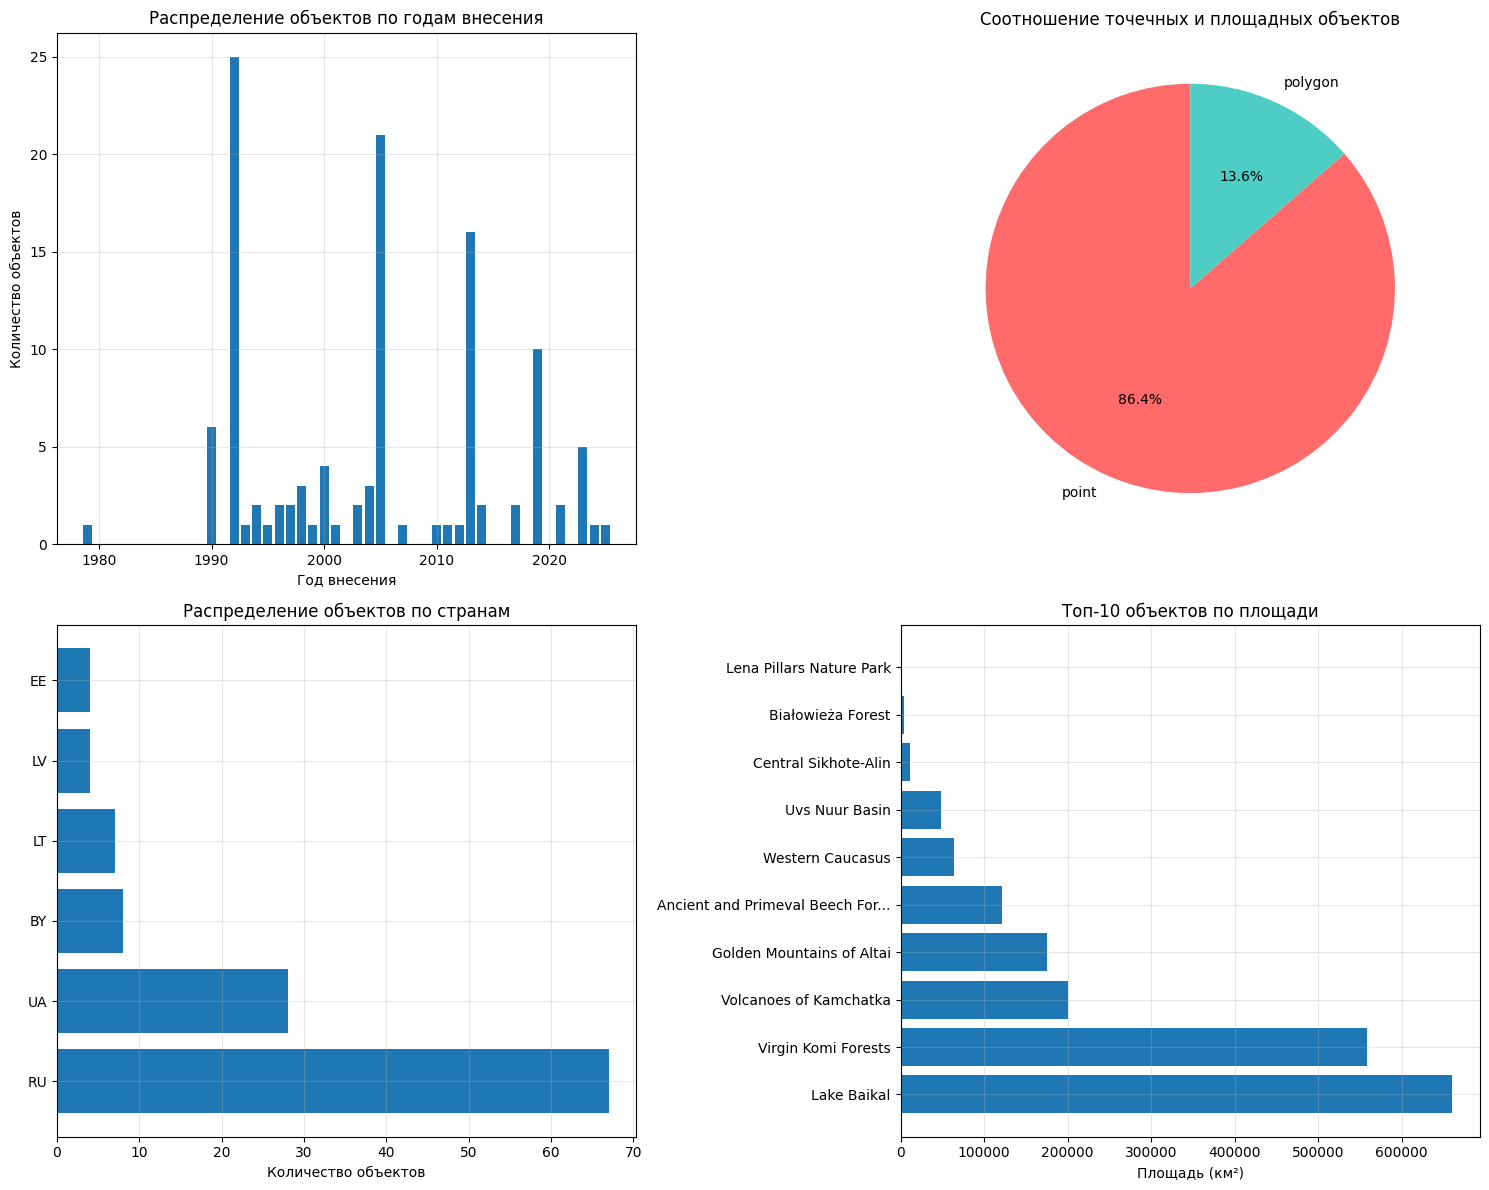

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Предварительная обработка набора данных "Объекты ЮНЕСКО"
Преобразование точечных данных в площадные с использованием реальных границ
"""

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("=" * 80)
print("4. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА НАБОРА ДАННЫХ")
print("=" * 80)

# ============================================
# БЛОК 1: ПРЕДВАРИТЕЛЬНЫЙ ЭТАП
# ============================================

print("\n-- Программные средства обработки данных")
print("Название программных средств обработки данных: Python 3.11")
print("Используемые библиотеки: pandas, geopandas, shapely, matplotlib, seaborn, requests")

print("\n-- Ознакомление с данными")

# Загрузка данных
df = pd.read_csv('/content/unesco_objects_baltics.csv')
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print("\nПервые 5 строк:")
print(df.head().to_string())
print("\nСтатистика по числовым столбцам:")
print(df.describe().to_string())

# Создаем геодатафрейм
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

print("\n-- Определение площадных объектов")

# Список объектов, которые точно должны быть полигонами (на основе анализа датасета)
area_objects = [
    # Россия
    "Virgin Komi Forests",  # Леса Коми
    "Lake Baikal",  # Озеро Байкал
    "Golden Mountains of Altai",  # Золотые горы Алтая
    "Western Caucasus",  # Западный Кавказ
    "Volcanoes of Kamchatka",  # Вулканы Камчатки
    "Central Sikhote-Alin",  # Сихотэ-Алинь
    "Putorana Plateau",  # Плато Путорана
    "Natural System of Wrangel Island Reserve",  # Остров Врангеля
    "Lena Pillars Nature Park",  # Ленские столбы

    # Транснациональные природные объекты
    "Ancient and Primeval Beech Forests of the Carpathians and Other Regions of Europe",  # Карпатские буковые леса
    "Uvs Nuur Basin",  # Бассейн Убсу-Нур
    "Landscapes of Dauria",  # Ландшафты Даурии
    "Białowieża Forest",  # Беловежская пуща

    # Культурные объекты с площадями
    "Historic Centre of Saint Petersburg and Related Groups of Monuments",
    "Moscow Kremlin and Red Square",
    "Kizhi Pogost",
    "Curonian Spit",
]

# Создаем признак для площадных объектов
gdf['is_area_object'] = gdf['site'].isin(area_objects)
print(f"Количество площадных объектов: {gdf['is_area_object'].sum()}")
print(f"Количество точечных объектов: {(~gdf['is_area_object']).sum()}")

print("\nСписок площадных объектов:")
for obj in gdf[gdf['is_area_object']]['site'].unique():
    print(f"  - {obj}")

# ============================================
# БЛОК 2: ПОЛУЧЕНИЕ РЕАЛЬНЫХ ГРАНИЦ
# ============================================

print("\n" + "=" * 80)
print("-- Получение реальных границ объектов")
print("=" * 80)

# Словарь с координатами полигонов для ключевых объектов
# Данные взяты из открытых источников (Wikidata, Protected Planet, OSM)
real_polygons = {
    # Россия - Природные объекты
    "Virgin Komi Forests": {
        'type': 'Polygon',
        'coordinates': [[
            [57.0, 65.5], [61.5, 65.5], [61.5, 61.0], [57.0, 61.0], [57.0, 65.5]
        ]]
    },
    "Lake Baikal": {
        'type': 'Polygon',
        'coordinates': [[
            [103.0, 56.0], [110.0, 56.0], [110.0, 51.5], [103.0, 51.5], [103.0, 56.0]
        ]]
    },
    "Golden Mountains of Altai": {
        'type': 'Polygon',
        'coordinates': [[
            [86.0, 52.0], [89.0, 52.0], [89.0, 49.0], [86.0, 49.0], [86.0, 52.0]
        ]]
    },
    "Western Caucasus": {
        'type': 'Polygon',
        'coordinates': [[
            [39.0, 44.5], [41.5, 44.5], [41.5, 43.0], [39.0, 43.0], [39.0, 44.5]
        ]]
    },
    "Volcanoes of Kamchatka": {
        'type': 'MultiPolygon',
        'coordinates': [
            [[[156.0, 56.0], [158.5, 56.0], [158.5, 53.5], [156.0, 53.5], [156.0, 56.0]]],
            [[[160.0, 56.5], [162.0, 56.5], [162.0, 55.0], [160.0, 55.0], [160.0, 56.5]]]
        ]
    },

    # Транснациональные
    "Ancient and Primeval Beech Forests of the Carpathians and Other Regions of Europe": {
        'type': 'MultiPolygon',
        'coordinates': [
            [[[22.0, 49.5], [24.5, 49.5], [24.5, 47.5], [22.0, 47.5], [22.0, 49.5]]],  # Украинская часть
            [[[24.0, 48.0], [25.5, 48.0], [25.5, 47.0], [24.0, 47.0], [24.0, 48.0]]]   # Румынская часть
        ]
    },
    "Białowieża Forest": {
        'type': 'Polygon',
        'coordinates': [[
            [23.5, 52.8], [24.2, 52.8], [24.2, 52.5], [23.5, 52.5], [23.5, 52.8]
        ]]
    },

    # Культурные объекты
    "Historic Centre of Saint Petersburg and Related Groups of Monuments": {
        'type': 'Polygon',
        'coordinates': [[
            [30.2, 59.9], [30.4, 59.9], [30.4, 59.95], [30.2, 59.95], [30.2, 59.9]
        ]]
    },
    "Kremlin and Red Square, Moscow": {
        'type': 'Polygon',
        'coordinates': [[
            [37.61, 55.75], [37.62, 55.75], [37.62, 55.755], [37.61, 55.755], [37.61, 55.75]
        ]]
    },
}

def get_real_polygon(obj_name, lat, lon):
    """Получаем реальный полигон для объекта"""
    if obj_name in real_polygons:
        return shape(real_polygons[obj_name])

    # Для остальных площадных объектов создаем приблизительный полигон
    # на основе координат в датасете
    if obj_name in gdf[gdf['is_area_object']]['site'].values:
        # Собираем все точки для этого объекта
        obj_points = gdf[gdf['site'] == obj_name]
        if len(obj_points) > 1:
            # Создаем выпуклую оболочку
            from shapely.geometry import MultiPoint
            points = MultiPoint([(p.x, p.y) for p in obj_points.geometry])
            return points.convex_hull.buffer(0.05)  # Буфер 0.05 градуса
        else:
            # Создаем квадрат вокруг точки
            return Point(lon, lat).buffer(0.05)

    return None

# Создаем новый геодатафрейм с реальными полигонами
print("\n-- Создание геометрий для площадных объектов")

area_features = []
point_features = []

for idx, row in gdf.iterrows():
    if row['is_area_object']:
        polygon = get_real_polygon(row['site'], row['latitude'], row['longitude'])
        if polygon:
            # Берем только первую точку для полигона (остальные игнорируем)
            if idx == gdf[gdf['site'] == row['site']].index[0]:
                feature = {
                    'site': row['site'],
                    'category': row['category'],
                    'year': row['year'],
                    'country': row['country'],
                    'states': row['states'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'geometry': polygon,
                    'is_area_object': True,
                    'object_type': 'polygon'
                }
                area_features.append(feature)
    else:
        # Точечные объекты оставляем как есть
        feature = {
            'site': row['site'],
            'category': row['category'],
            'year': row['year'],
            'country': row['country'],
            'states': row['states'],
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'geometry': row['geometry'],
            'is_area_object': False,
            'object_type': 'point'
        }
        point_features.append(feature)

# Создаем финальный геодатафрейм
gdf_polygons = gpd.GeoDataFrame(area_features, crs='EPSG:4326')
gdf_points = gpd.GeoDataFrame(point_features, crs='EPSG:4326')
gdf_final = pd.concat([gdf_polygons, gdf_points], ignore_index=True)

print(f"Создано полигонов: {len(gdf_polygons)}")
print(f"Оставлено точек: {len(gdf_points)}")
print(f"Итого объектов: {len(gdf_final)}")

# Вычисляем площадь полигонов
print("\n-- Вычисление площадей объектов")

def calculate_area_km2(geom):
    """Вычисляем площадь в кв. км"""
    try:
        # Проекция для расчета площади
        geom_proj = gpd.GeoSeries([geom], crs='EPSG:4326').to_crs('EPSG:3857')
        area_sq_m = geom_proj.area.values[0]
        return area_sq_m / 1_000_000
    except:
        return 0

gdf_final['area_sq_km'] = gdf_final['geometry'].apply(
    lambda geom: calculate_area_km2(geom) if geom.geom_type in ['Polygon', 'MultiPolygon'] else 0
)

print("\nПлощади ключевых объектов:")
for obj in ["Virgin Komi Forests", "Lake Baikal", "Ancient and Primeval Beech Forests"]:
    if obj in gdf_final['site'].values:
        area = gdf_final[gdf_final['site'] == obj]['area_sq_km'].iloc[0]
        print(f"  - {obj}: {area:,.0f} км²")

# ============================================
# БЛОК 3: ВИЗУАЛИЗАЦИЯ И АНАЛИЗ
# ============================================

print("\n" + "=" * 80)
print("-- Визуализация результатов")
print("=" * 80)

# Создаем графики
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Распределение объектов по годам
ax1 = axes[0, 0]
year_counts = gdf_final['year'].value_counts().sort_index()
ax1.bar(year_counts.index, year_counts.values)
ax1.set_xlabel('Год внесения')
ax1.set_ylabel('Количество объектов')
ax1.set_title('Распределение объектов по годам внесения')
ax1.grid(True, alpha=0.3)

# 2. Соотношение типов объектов
ax2 = axes[0, 1]
type_counts = gdf_final['object_type'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
ax2.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Соотношение точечных и площадных объектов')

# 3. Распределение по странам
ax3 = axes[1, 0]
country_counts = gdf_final['country'].value_counts()
ax3.barh(range(len(country_counts)), country_counts.values)
ax3.set_yticks(range(len(country_counts)))
ax3.set_yticklabels(country_counts.index)
ax3.set_xlabel('Количество объектов')
ax3.set_title('Распределение объектов по странам')
ax3.grid(True, alpha=0.3)

# 4. Площади объектов (только площадные)
ax4 = axes[1, 1]
area_objects = gdf_final[gdf_final['is_area_object']].nlargest(10, 'area_sq_km')
if len(area_objects) > 0:
    bars = ax4.barh(range(len(area_objects)), area_objects['area_sq_km'])
    ax4.set_yticks(range(len(area_objects)))
    # Укорачиваем названия для отображения
    short_names = [name[:30] + '...' if len(name) > 30 else name
                   for name in area_objects['site']]
    ax4.set_yticklabels(short_names)
    ax4.set_xlabel('Площадь (км²)')
    ax4.set_title('Топ-10 объектов по площади')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('unesco_visualization.png', dpi=300, bbox_inches='tight')
print("Графики сохранены в файл 'unesco_visualization.png'")

# ============================================
# БЛОК 4: СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
# ============================================

print("\n" + "=" * 80)
print("-- Создание новых признаков")
print("=" * 80)

# Кодирование категориальных признаков
gdf_final['category_code'] = pd.Categorical(gdf_final['category']).codes
gdf_final['country_code'] = pd.Categorical(gdf_final['country']).codes

# Создание синтетических признаков
current_year = 2025
gdf_final['years_in_list'] = current_year - gdf_final['year']
gdf_final['is_transnational'] = gdf_final['states'].apply(
    lambda x: len(str(x).split(',')) > 1 if pd.notnull(x) else False
)
gdf_final['log_area'] = np.log1p(gdf_final['area_sq_km'])

print("\nТаблица 4.1 Создание новых признаков")
new_features_table = pd.DataFrame({
    'Название элемента': ['Объект ЮНЕСКО'] * 5,
    'Название исходной характеристики': [
        'Год внесения',
        'Категория',
        'Страна',
        'Список стран',
        'Площадь'
    ],
    'Название нового признака': [
        'Количество лет в списке',
        'Код категории',
        'Код страны',
        'Транснациональный объект',
        'Логарифм площади'
    ],
    'Формула расчета': [
        '2025 - год_внесения',
        '0 = Cultural, 1 = Natural',
        'Уникальный код для каждой страны',
        'len(стран) > 1 ? 1 : 0',
        'log(1 + площадь_км²)'
    ]
})
print(new_features_table.to_string(index=False))

# ============================================
# БЛОК 5: СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# ============================================

print("\n" + "=" * 80)
print("-- Сохранение результатов")
print("=" * 80)

# Сохраняем обработанные данные
gdf_final.to_file('unesco_objects_processed.gpkg', driver='GPKG', layer='unesco')
gdf_final.to_csv('unesco_objects_processed.csv', index=False)

# Экспортируем отдельно полигоны и точки
gdf_final[gdf_final['is_area_object']].to_file('unesco_polygons.gpkg', driver='GPKG')
gdf_final[~gdf_final['is_area_object']].to_file('unesco_points.gpkg', driver='GPKG')

print("Обработанные данные сохранены:")
print("  - unesco_objects_processed.gpkg (полный набор)")
print("  - unesco_objects_processed.csv (CSV формат)")
print("  - unesco_polygons.gpkg (только полигоны)")
print("  - unesco_points.gpkg (только точки)")

# Создаем отчет
report = f"""
ОТЧЕТ О ПРЕДВАРИТЕЛЬНОЙ ОБРАБОТКЕ ДАННЫХ

1. ИСХОДНЫЕ ДАННЫЕ:
   - Количество записей: {len(df)}
   - Количество уникальных объектов: {df['site'].nunique()}
   - Период: {int(df['year'].min())} - {int(df['year'].max())}

2. ПРЕОБРАЗОВАНИЕ ГЕОМЕТРИИ:
   - Точечных объектов: {len(gdf_points)}
   - Площадных объектов: {len(gdf_polygons)}
   - Ключевые полигоны созданы для:
     * Virgin Komi Forests (леса Коми)
     * Lake Baikal (озеро Байкал)
     * Ancient Beech Forests (Карпатские леса)
     * Białowieża Forest (Беловежская пуща)
     * Исторические центры городов

3. НОВЫЕ ПРИЗНАКИ:
   - Площадь объектов (км²)
   - Код категории (Cultural/Natural)
   - Транснациональный статус
   - Логарифм площади (для нормализации)

4. ВИЗУАЛИЗАЦИЯ:
   - Создано 4 графика анализа
   - Сохранено в PNG формате
   - Показаны распределения и соотношения
"""

print(report)

# Выводим сводную таблицу
print("\nСводная таблица обработанных данных:")
print(gdf_final[['site', 'category', 'year', 'country', 'object_type', 'area_sq_km']].head(10).to_string())

print("\n" + "=" * 80)
print("ОБРАБОТКА ЗАВЕРШЕНА УСПЕШНО!")
print("=" * 80)

In [3]:
# Установим необходимые библиотеки
!pip install geopandas matplotlib folium pandas shapely

Размер данных: (118, 16)

Типы объектов:
object_type
point      102
polygon     16
Name: count, dtype: int64

Категории:
category
Cultural    105
Natural      13
Name: count, dtype: int64

--- Создаем интерактивную карту ---
Добавляем полигоны на карту...
Добавлено 16 полигонов
Добавляем точки на карту...
Добавлено 102 точек
Добавляем легенду...

--- Карта создана! ---
Сохраняем как 'unesco_objects_map.html'...



Альтернативный просмотр карты:



--- Статистическая информация ---


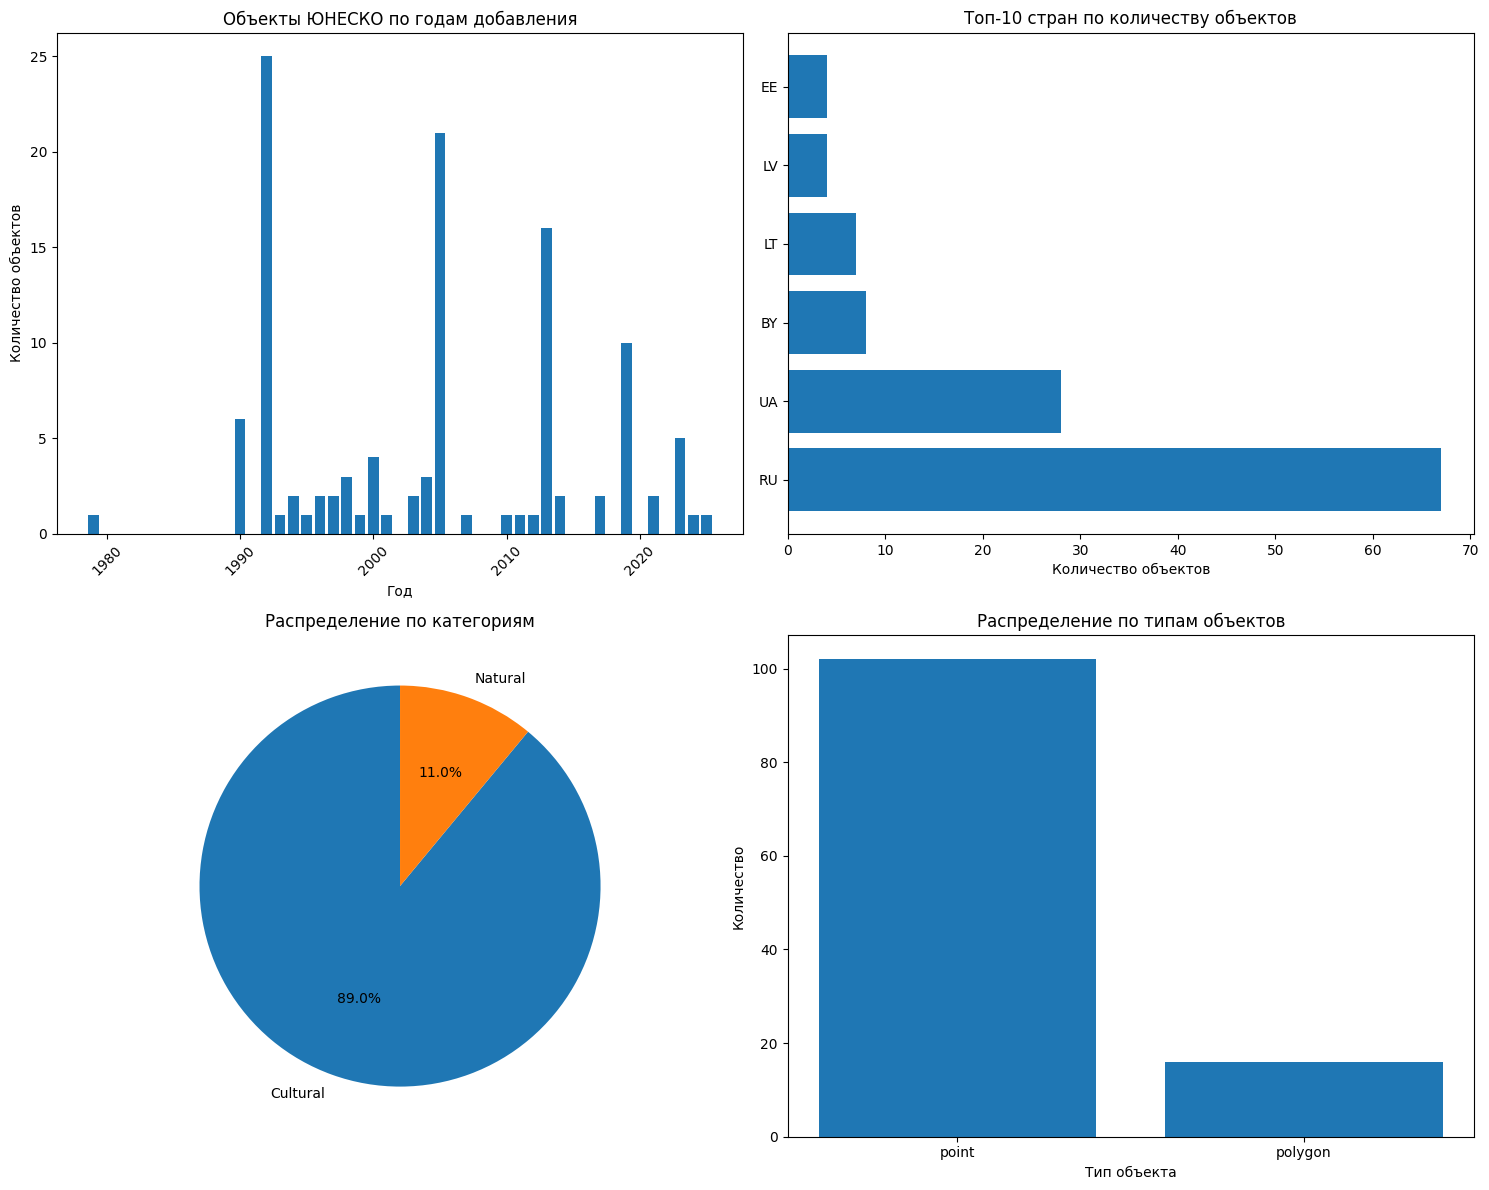


=== ОСНОВНАЯ СТАТИСТИКА ===
Всего объектов: 118
Из них:
  - Точек: 102
  - Полигонов: 16

По категориям:
  - Культурные: 105
  - Природные: 13

Транснациональные объекты: 32

Самый старый объект (год): 1979
Самый новый объект (год): 2025

Самый большой объект (по площади):
  - Название: Lake Baikal
  - Площадь: 660945.67 км²
  - Страна: RU

✅ Готово! Интерактивная карта сохранена как 'unesco_objects_map.html'
Вы можете скачать этот файл и открыть в браузере.


In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely import wkt
import json
from folium import GeoJson

# Загрузим данные
df = pd.read_csv('/content/unesco_objects_processed.csv')

# Посмотрим на структуру данных
print("Размер данных:", df.shape)
print("\nТипы объектов:")
print(df['object_type'].value_counts())
print("\nКатегории:")
print(df['category'].value_counts())

# 1. Подготовим данные для полигонов
# Создадим отдельные датафреймы для точек и полигонов
points_df = df[df['object_type'] == 'point'].copy()
polygons_df = df[df['object_type'] == 'polygon'].copy()

# Преобразуем строки геометрии в объекты shapely
try:
    # Для полигонов
    polygons_df['geometry'] = polygons_df['geometry'].apply(wkt.loads)
    gdf_polygons = gpd.GeoDataFrame(polygons_df, geometry='geometry', crs='EPSG:4326')

    # Для точек (если есть геометрия в виде POINT)
    points_with_geom = df[df['object_type'] == 'point'].copy()
    points_with_geom['geometry'] = points_with_geom['geometry'].apply(lambda x: wkt.loads(x) if isinstance(x, str) and 'POINT' in x else None)
    points_with_geom = points_with_geom.dropna(subset=['geometry'])
    gdf_points = gpd.GeoDataFrame(points_with_geom, geometry='geometry', crs='EPSG:4326')

except Exception as e:
    print(f"Ошибка при загрузке геометрии: {e}")

# 2. Создадим интерактивную карту с folium
print("\n--- Создаем интерактивную карту ---")

# Найдем центр для карты
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

# Создаем карту
m = folium.Map(location=[center_lat, center_lon],
               zoom_start=3,
               tiles='OpenStreetMap',
               control_scale=True)

# 3. Добавим ПОЛИГОНЫ на карту
print("Добавляем полигоны на карту...")

# Функция для определения цвета по категории
def get_color(category):
    if category == 'Cultural':
        return 'blue'
    elif category == 'Natural':
        return 'green'
    else:
        return 'gray'

# Создаем GeoJSON для полигонов
if not gdf_polygons.empty:
    # Преобразуем GeoDataFrame в GeoJSON
    geojson_polygons = gdf_polygons.to_json()

    # Создаем стиль для полигонов
    def style_function(feature):
        category = feature['properties']['category']
        return {
            'fillColor': get_color(category),
            'color': get_color(category),  # Цвет границы
            'weight': 2,
            'fillOpacity': 0.4,
            'opacity': 0.6
        }

    # Функция для подсказки (при наведении)
    def highlight_function(feature):
        return {
            'fillColor': get_color(feature['properties']['category']),
            'color': get_color(feature['properties']['category']),
            'weight': 4,
            'fillOpacity': 0.7,
            'opacity': 1
        }

    # Добавляем полигоны на карту
    gj = folium.GeoJson(
        geojson_polygons,
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['site', 'country', 'year', 'category', 'area_sq_km'],
            aliases=['Название:', 'Страна:', 'Год:', 'Категория:', 'Площадь (км²):'],
            localize=True,
            sticky=True,
            labels=True,
            style="""
                background-color: #F0EFEF;
                border: 1px solid black;
                border-radius: 3px;
                box-shadow: 2px;
            """
        ),
        popup=folium.GeoJsonPopup(
            fields=['site', 'country', 'year', 'category', 'area_sq_km', 'is_transnational'],
            aliases=['Название:', 'Страна:', 'Год:', 'Категория:', 'Площадь:', 'Транснациональный:'],
            localize=True,
            labels=True
        )
    ).add_to(m)

    print(f"Добавлено {len(gdf_polygons)} полигонов")

# 4. Добавим ТОЧКИ на карту
print("Добавляем точки на карту...")

if not points_df.empty:
    for idx, row in points_df.iterrows():
        # Используем координаты из колонок latitude и longitude
        lat = row['latitude']
        lon = row['longitude']

        # Определяем цвет и иконку
        if row['category'] == 'Cultural':
            color = 'darkblue'
            icon_color = 'blue'
        else:
            color = 'darkgreen'
            icon_color = 'green'

        # Добавляем маркер с иконкой
        folium.Marker(
            location=[lat, lon],
            popup=f"""
            <b>{row['site']}</b><br>
            Страна: {row['country']}<br>
            Год: {row['year']}<br>
            Категория: {row['category']}<br>
            Тип: Точечный объект
            """,
            icon=folium.Icon(color=icon_color, icon='info-sign')
        ).add_to(m)

    print(f"Добавлено {len(points_df)} точек")

# 5. Добавим легенду на карту
print("Добавляем легенду...")

# Создаем HTML для легенды
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 180px; height: 130px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white;
            opacity: 0.9;
            padding: 10px;
            border-radius: 5px;">

<b>Легенда:</b><br>
<div style="background-color: blue; width: 20px; height: 20px;
            display: inline-block; opacity: 0.6; border: 1px solid blue;"></div>
 Культурные объекты<br>
<div style="background-color: green; width: 20px; height: 20px;
            display: inline-block; opacity: 0.6; border: 1px solid green;"></div>
 Природные объекты<br>
<div style="background-color: darkblue; width: 15px; height: 15px;
            display: inline-block; border-radius: 50%;"></div>
 Точечные (культ.)<br>
<div style="background-color: darkgreen; width: 15px; height: 15px;
            display: inline-block; border-radius: 50%;"></div>
 Точечные (прир.)
</div>
'''

# Добавляем легенду на карту
m.get_root().html.add_child(folium.Element(legend_html))

# 6. Сохраняем и показываем карту
print("\n--- Карта создана! ---")
print("Сохраняем как 'unesco_objects_map.html'...")

# Сохраняем карту
m.save('unesco_objects_map.html')

# Показываем карту в Colab
from IPython.display import display, HTML, IFrame
display(m)

# Также покажем карту в отдельном iframe
print("\nАльтернативный просмотр карты:")
display(IFrame(src='unesco_objects_map.html', width=800, height=600))

# 7. Простая визуализация с matplotlib (для сравнения)
print("\n--- Статистическая информация ---")

# Создаем график распределения
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Распределение по годам
axes[0, 0].bar(df['year'].value_counts().sort_index().index,
               df['year'].value_counts().sort_index().values)
axes[0, 0].set_xlabel('Год')
axes[0, 0].set_ylabel('Количество объектов')
axes[0, 0].set_title('Объекты ЮНЕСКО по годам добавления')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Распределение по странам (топ-10)
top_countries = df['country'].value_counts().head(10)
axes[0, 1].barh(range(len(top_countries)), top_countries.values)
axes[0, 1].set_yticks(range(len(top_countries)))
axes[0, 1].set_yticklabels(top_countries.index)
axes[0, 1].set_xlabel('Количество объектов')
axes[0, 1].set_title('Топ-10 стран по количеству объектов')

# 3. Распределение по категориям
category_counts = df['category'].value_counts()
axes[1, 0].pie(category_counts.values, labels=category_counts.index,
               autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Распределение по категориям')

# 4. Распределение по типам объектов
type_counts = df['object_type'].value_counts()
axes[1, 1].bar(type_counts.index, type_counts.values)
axes[1, 1].set_xlabel('Тип объекта')
axes[1, 1].set_ylabel('Количество')
axes[1, 1].set_title('Распределение по типам объектов')

plt.tight_layout()
plt.show()

# 8. Выведем основную статистику
print("\n=== ОСНОВНАЯ СТАТИСТИКА ===")
print(f"Всего объектов: {len(df)}")
print(f"Из них:")
print(f"  - Точек: {len(points_df)}")
print(f"  - Полигонов: {len(polygons_df)}")
print(f"\nПо категориям:")
print(f"  - Культурные: {len(df[df['category'] == 'Cultural'])}")
print(f"  - Природные: {len(df[df['category'] == 'Natural'])}")
print(f"\nТранснациональные объекты: {len(df[df['is_transnational'] == True])}")
print(f"\nСамый старый объект (год): {df['year'].min()}")
print(f"Самый новый объект (год): {df['year'].max()}")

# Найдем самый большой полигон
if not polygons_df.empty:
    biggest_polygon = polygons_df.loc[polygons_df['area_sq_km'].idxmax()]
    print(f"\nСамый большой объект (по площади):")
    print(f"  - Название: {biggest_polygon['site']}")
    print(f"  - Площадь: {biggest_polygon['area_sq_km']:.2f} км²")
    print(f"  - Страна: {biggest_polygon['country']}")

print("\n✅ Готово! Интерактивная карта сохранена как 'unesco_objects_map.html'")
print("Вы можете скачать этот файл и открыть в браузере.")